# HW 4: MLE/MAP

## Maximum Likelihood Estimation (MLE) and Maximum a Posteriori (MAP)
Consider the theory and the notation provided in the the MLE/MAP section (https://devangelista2.github.io/statistical-mathematical-methods/regression_classification/MLE_MAP.html). Let $f_\theta(x)$ be a polynomial regression model as in the previous Homework, and let the `poly_regression_small.csv` from Virtuale be the training set. Then, sample 20% of the data in the `poly_regression_large.csv` dataset to use as test set.

* For a given value of $K$, write three Python functions computing $\theta_{MLE}$, i.e. the optimal parameters obtained by optimizing the MLE-related loss function with Gaussian assumption on the likelihood $p_\theta(y | x)$, by Gradient Descent, Stochastic Gradient Descent (with a `batch_size` = 5), and Normal Equations method with Cholesky Decomposition.
* Compare the performance of the three regression model computed above. In particular, if $(X_{test}, Y_{test})$ is the test set from the `poly_regression_large.csv` dataset, for each of the model, compute:

  $$
  Err = \frac{1}{N_{test}} \sum_{i=1}^{N_{test}} (f_\theta(x^i) - y^i)^2,
  $$

  where $N_{test}$ is the number of elements in the test set, $(x^i, y^i)$ are the input and output elements in the test set. Comment the performance of the three models. 
* For different values of $K$, plot the training datapoints and the test datapoints with different colors and visualize (as a continuous line) the three learned regression model $f_\theta(x)$. Comment the results.
* For increasing values of $K$, compute the training and test error as discussed above. Plot the two errors with respect to $K$. Comment the results.
* Repeat the same experiments by considering the MAP formulation with Gaussian assumption on the prior term $p(\theta)$. Set $K = 8$ and test different values of $\lambda > 0$ in the experiments. Comment the results, comparing:
  - the three optimization method used to obtain $\theta_{MAP}$ (i.e. GD, SGD and Normal Equations),
  - the different values of $\lambda > 0$ tested,
  - the results obtained by $\theta_{MLE}$ vs $\theta_{MAP}$.

In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

In [173]:
# Load small dataset for training
train_data = pd.read_csv('poly_regression_small.csv')
X_train = train_data['x'].values.reshape(-1, 1)
Y_train = train_data['y'].values

# Load large dataset for testing
large_data = pd.read_csv('poly_regression_large.csv')
X_large = large_data['x'].values.reshape(-1, 1)
Y_large = large_data['y'].values

# Split large dataset
X_test, _, Y_test, _ = train_test_split(X_large, Y_large, test_size=0.8, random_state=42)

# Load data
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape) 


(50, 1) (50,) (200, 1) (200,)


In [174]:
# Polynomial features
def polynomial_features(X, K):
    poly = PolynomialFeatures(degree=K)
    return poly.fit_transform(X)

In [175]:
def gradient_descent(X, Y, grad_f, learning_rate=0.01, max_iter=10000, **kwargs):
    """
    Gradient Descent for parameter estimation
    
    Args:
        X (np.ndarray): Polynomial feature matrix
        Y (np.ndarray): Target values
        learning_rate (float): Learning rate
        max_iter (int): Maximum iterations
    
    Returns:
        np.ndarray: Estimated parameters
    """
    theta = np.zeros(X.shape[1])
    for _ in range(max_iter):
        gradient = grad_f(X, Y, theta, **kwargs)
        theta -= learning_rate * gradient
    return theta

def stochastic_gradient_descent(X, Y, grad_f, batch_size=5, learning_rate=0.01, max_iter=10000 , **kwargs):
    """
    Stochastic Gradient Descent for parameter estimation
    
    Args:
        X (np.ndarray): Polynomial feature matrix
        Y (np.ndarray): Target values
        batch_size (int): Mini-batch size
        learning_rate (float): Learning rate
        max_iter (int): Maximum iterations
    
    Returns:
        np.ndarray: Estimated parameters
    """
    theta = np.zeros(X.shape[1])
    n_samples = len(Y)
    
    for _ in range(max_iter):
        indices = np.random.choice(n_samples, batch_size, replace=False)
        X_batch = X[indices]
        Y_batch = Y[indices]

        gradient = grad_f(X_batch, Y_batch, theta, **kwargs)
        theta -= learning_rate * gradient
    
    return theta


In [176]:
def normal_equations_cholesky(X, Y):
    """
    Normal Equations with Cholesky Decomposition
    
    Args:
        X (np.ndarray): Polynomial feature matrix
        Y (np.ndarray): Target values
    
    Returns:
        np.ndarray: Estimated parameters
    """
    # Calcolare X^T X
    XtX = X.T @ X
    
    # Calcolare X^T Y
    XtY = X.T @ Y
    
    # Fattorizzare X^T X utilizzando la decomposizione di Cholesky
    L = np.linalg.cholesky(XtX)
    
    # Risolvere L gamma = X^T Y per gamma
    gamma = np.linalg.solve(L, XtY)
    
    # Risolvere L^T theta = gamma per theta
    theta = np.linalg.solve(L.T, gamma)
    
    return theta

In [177]:
def compute_error(X, Y, theta):
    """
    Compute Mean Squared Error
    
    Args:
        X (np.ndarray): Input features
        Y (np.ndarray): Target values
        theta (np.ndarray): Model parameters
    
    Returns:
        float: Mean Squared Error
    """
    Y_pred = X @ theta
    return np.mean((Y_pred - Y)**2)

In [178]:
def plot_regression(X_train, Y_train, X_test, Y_test, thetas, K, labels):
    """
    Plot regression models
    
    Args:
        X_train (np.ndarray): Training input
        Y_train (np.ndarray): Training output
        X_test (np.ndarray): Test input
        Y_test (np.ndarray): Test output
        thetas (list): Estimated parameters for each method
        K (int): Polynomial degree
        labels (list): Method labels
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, Y_train, color='orange', label='Train Data', alpha=1)
    plt.scatter(X_test, Y_test, color='rebeccapurple', label='Test Data', alpha=0.5)

    x_line = np.linspace(min(X_train.min(), X_test.min()), # Provo a plottare in base a minimo e massimo per centrare il grafico
                         max(X_train.max(), X_test.max()), 100).reshape(-1, 1)
    poly_x_line = polynomial_features(x_line, K)

    for theta, label in zip(thetas, labels):
        y_line = poly_x_line @ theta
        plt.plot(x_line, y_line, label=label)

    plt.title(f'Polynomial Regression (K = {K})')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

In [179]:
def show_errors_and_plots(train_errors, test_errors, max_K):
    print("Errors:")
    print("Degree \t\t GD Test \t\t GD Train \t\t SGD Test \t\t SGD Train \t\t NE Test \t\t NE Train")
    for i in range(max_K):
        print(f"{i+1} \t\t {test_errors[i][0]:.4f} \t\t {train_errors[i][0]:.4f} \t\t "
              f"{test_errors[i][1]:.4f} \t\t {train_errors[i][1]:.4f} \t\t "
              f"{test_errors[i][2]:.4f} \t\t {train_errors[i][2]:.4f}")

    plt.figure(figsize=(10, 6))
    methods = ['GD', 'SGD', 'Normal Equations']
    for i in range(3):
        plt.plot(range(1, max_K + 1),
                 [errors[i] for errors in train_errors],
                 label=f'{methods[i]} Train')
        plt.plot(range(1, max_K + 1),
                 [errors[i] for errors in test_errors],
                 label=f'{methods[i]} Test')

    plt.title('Training and Test Errors vs Polynomial Degree')
    plt.xlabel('Polynomial Degree (K)')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

#### MLE

In [180]:
def mle_gradient(X, Y, theta):
    """
    MLE gradient computation
    
    Args:
        X (np.ndarray): Polynomial feature matrix
        Y (np.ndarray): Target values
        theta (np.ndarray): Current parameter estimates
    
    Returns:
        np.ndarray: Gradient for MLE
    """
    Y_pred = X @ theta
    return 2 * X.T @ (Y_pred - Y) / len(Y)

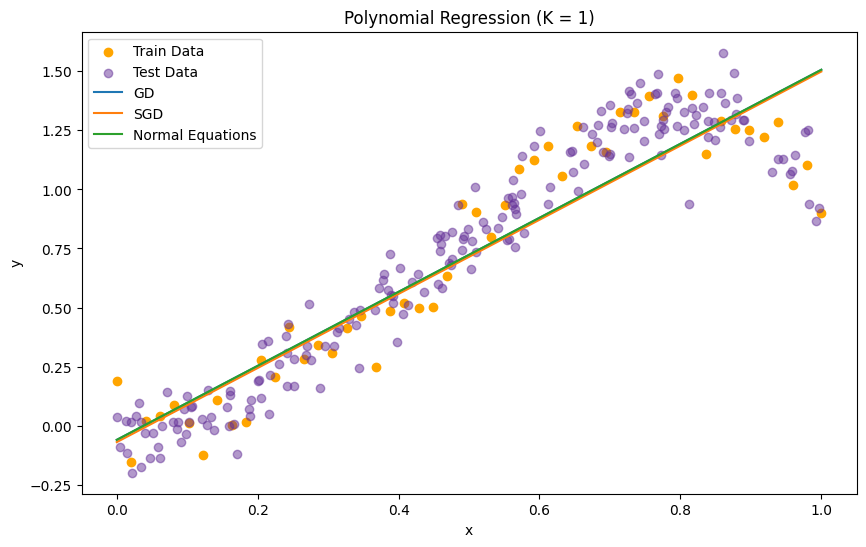

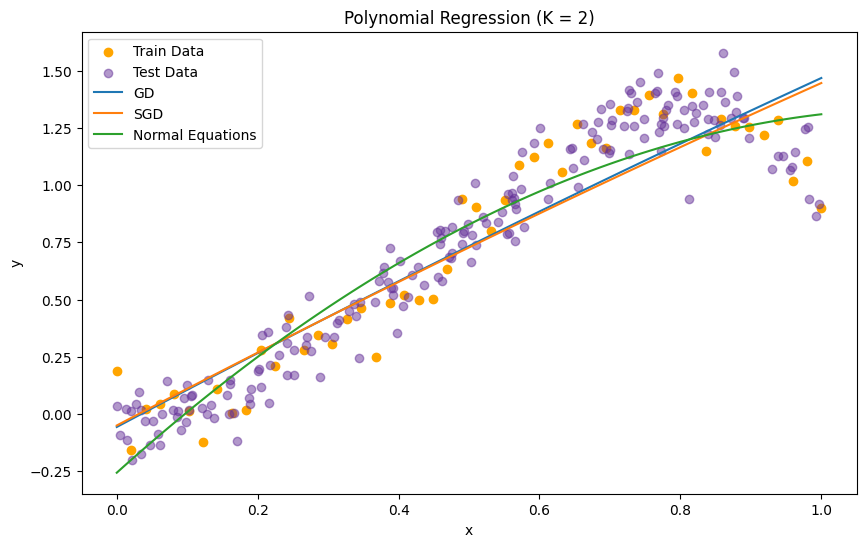

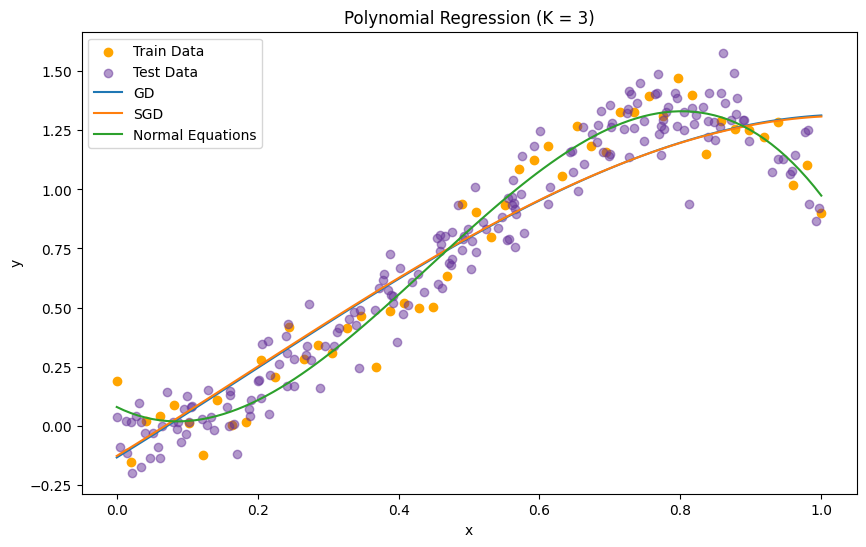

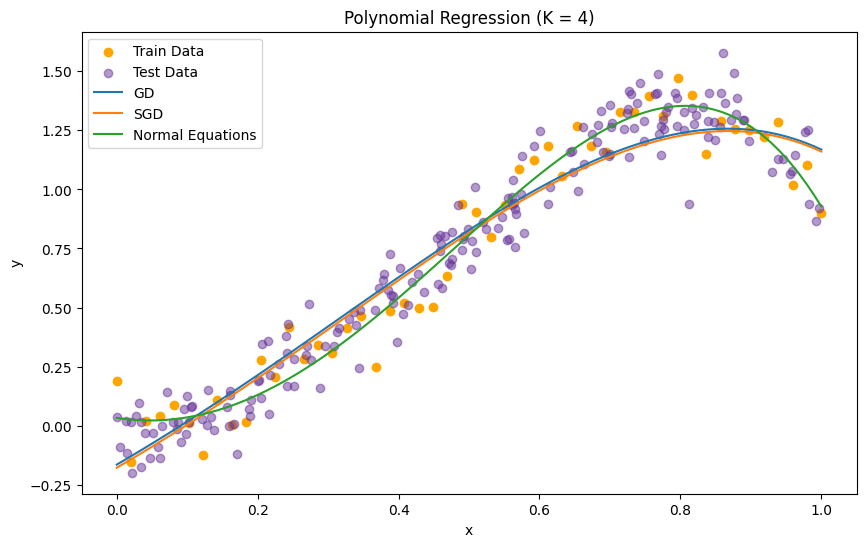

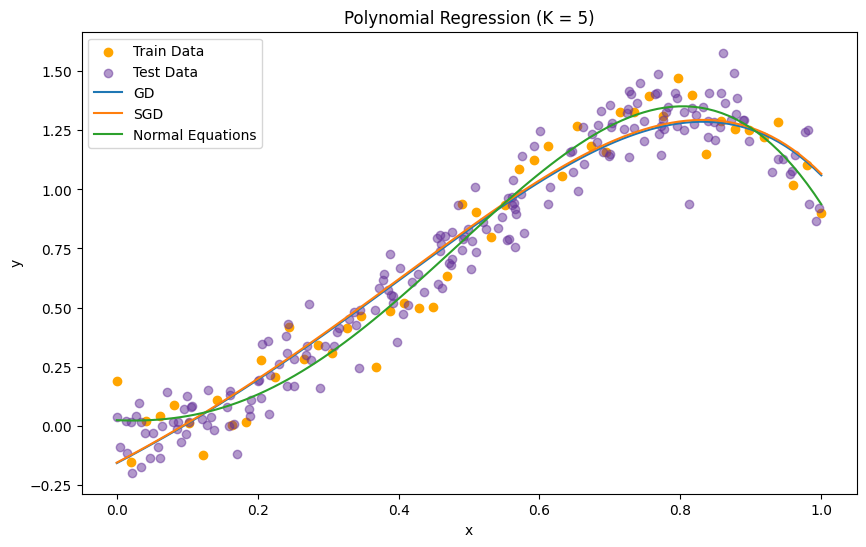

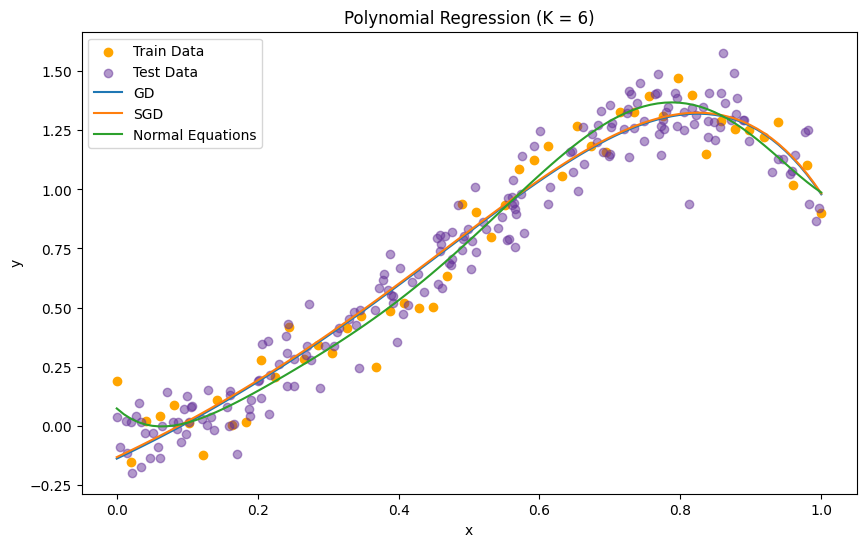

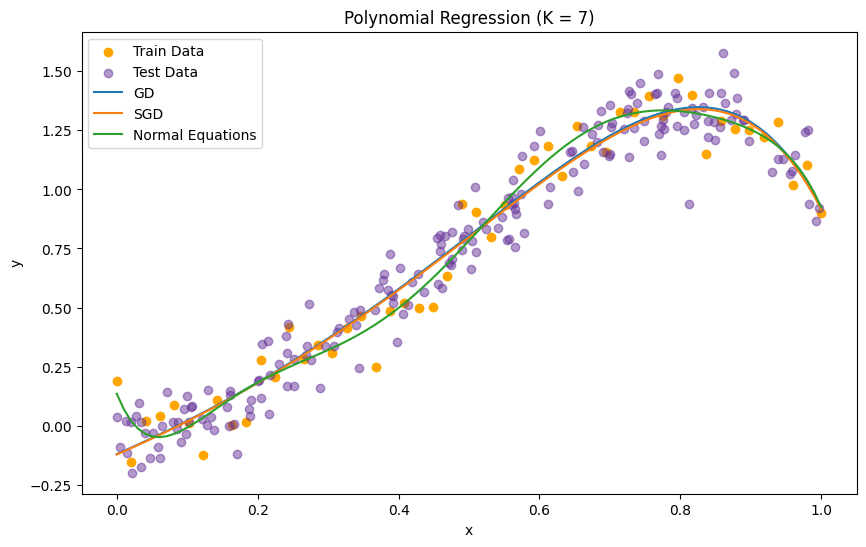

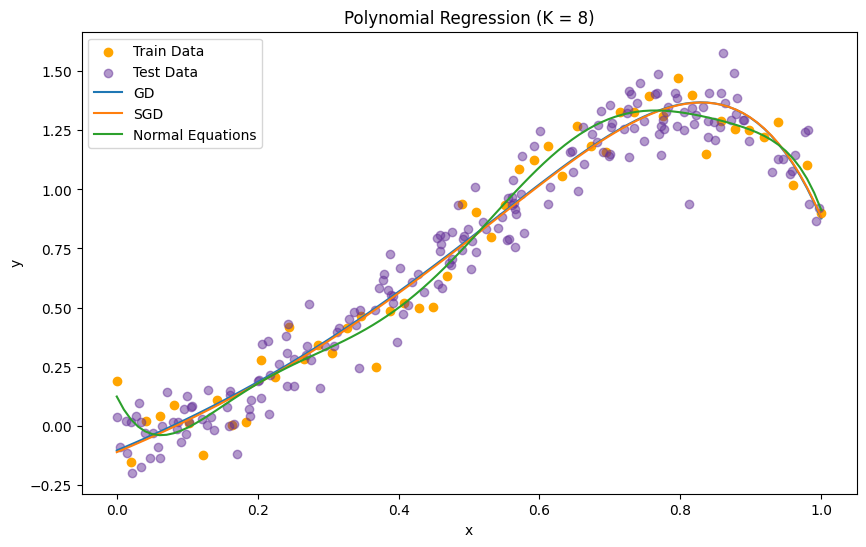

In [181]:
# Experiment with different polynomial degrees
max_K = 8
mle_train_errors = []
mle_test_errors = []

for K in range(1, max_K + 1):
    # Polynomial feature transformation
    X_train_poly = polynomial_features(X_train, K)
    X_test_poly = polynomial_features(X_test, K)

    # Estimation methods
    theta_gd = gradient_descent(X_train_poly, Y_train, mle_gradient)
    theta_sgd = stochastic_gradient_descent(X_train_poly, Y_train, mle_gradient)
    theta_ne = normal_equations_cholesky(X_train_poly, Y_train)

    # Compute errors
    gd_train_error = compute_error(X_train_poly, Y_train, theta_gd)
    sgd_train_error = compute_error(X_train_poly, Y_train, theta_sgd)
    ne_train_error = compute_error(X_train_poly, Y_train, theta_ne)

    gd_test_error = compute_error(X_test_poly, Y_test, theta_gd)
    sgd_test_error = compute_error(X_test_poly, Y_test, theta_sgd)
    ne_test_error = compute_error(X_test_poly, Y_test, theta_ne)

    # Visualization
    plot_regression(X_train, Y_train, X_test, Y_test, 
                    [theta_gd, theta_sgd, theta_ne], 
                    K, ['GD', 'SGD', 'Normal Equations'])

    # Store errors for plotting
    mle_train_errors.append([gd_train_error, sgd_train_error, ne_train_error])
    mle_test_errors.append([gd_test_error, sgd_test_error, ne_test_error])

Errors:
Degree 		 GD Test 		 GD Train 		 SGD Test 		 SGD Train 		 NE Test 		 NE Train
1 		 0.0289 		 0.0389 		 0.0292 		 0.0390 		 0.0289 		 0.0389
2 		 0.0283 		 0.0375 		 0.0292 		 0.0377 		 0.0217 		 0.0302
3 		 0.0195 		 0.0264 		 0.0196 		 0.0265 		 0.0112 		 0.0097
4 		 0.0141 		 0.0189 		 0.0144 		 0.0190 		 0.0107 		 0.0094
5 		 0.0114 		 0.0146 		 0.0113 		 0.0146 		 0.0108 		 0.0093
6 		 0.0101 		 0.0124 		 0.0102 		 0.0124 		 0.0108 		 0.0089
7 		 0.0098 		 0.0116 		 0.0098 		 0.0116 		 0.0113 		 0.0081
8 		 0.0100 		 0.0115 		 0.0100 		 0.0115 		 0.0113 		 0.0081


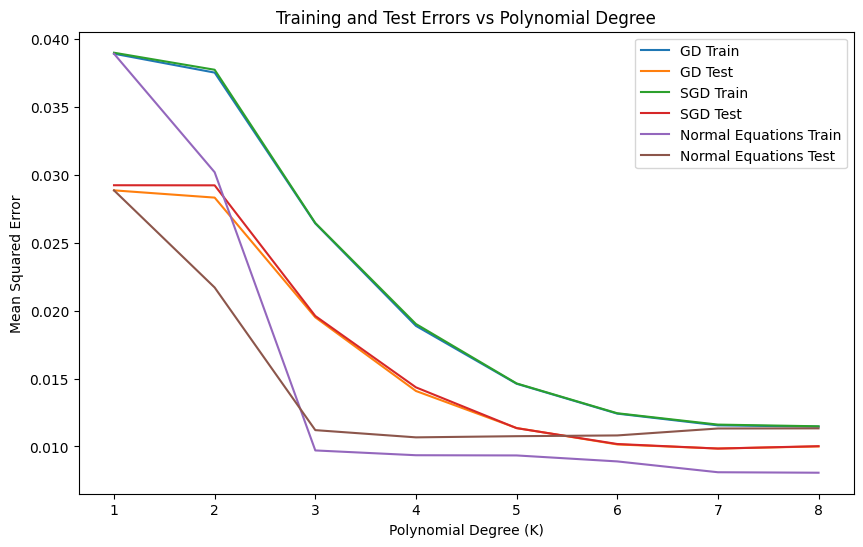

In [182]:
show_errors_and_plots(mle_train_errors, mle_test_errors, max_K)

#### MAP

In [183]:
def map_gradient(X, Y, theta, lam):
    """
    MAP gradient computation with L2 regularization
    
    Args:
        X (np.ndarray): Polynomial feature matrix
        Y (np.ndarray): Target values
        theta (np.ndarray): Current parameter estimates
        lam (float): Regularization strength
    
    Returns:
        np.ndarray: Gradient for MAP
    """
    Y_pred = X @ theta
    return 2 * X.T @ (Y_pred - Y) / len(Y) + 2 * lam * theta

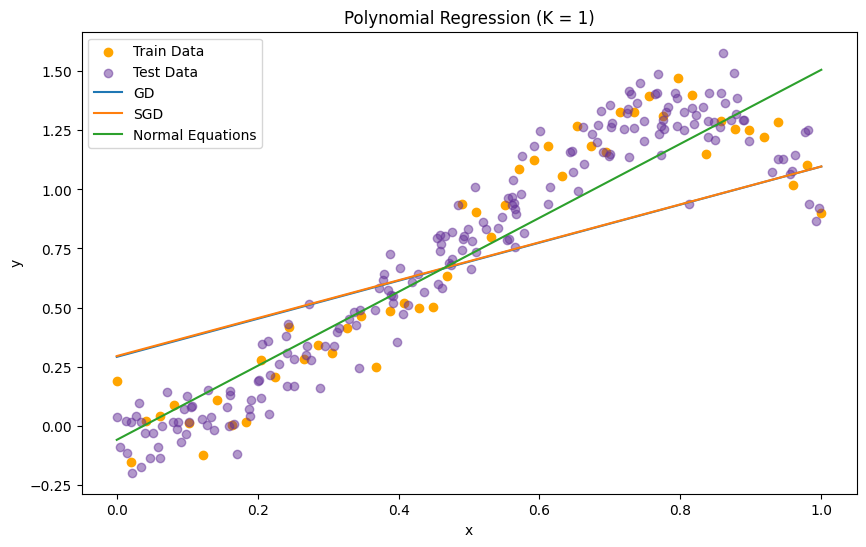

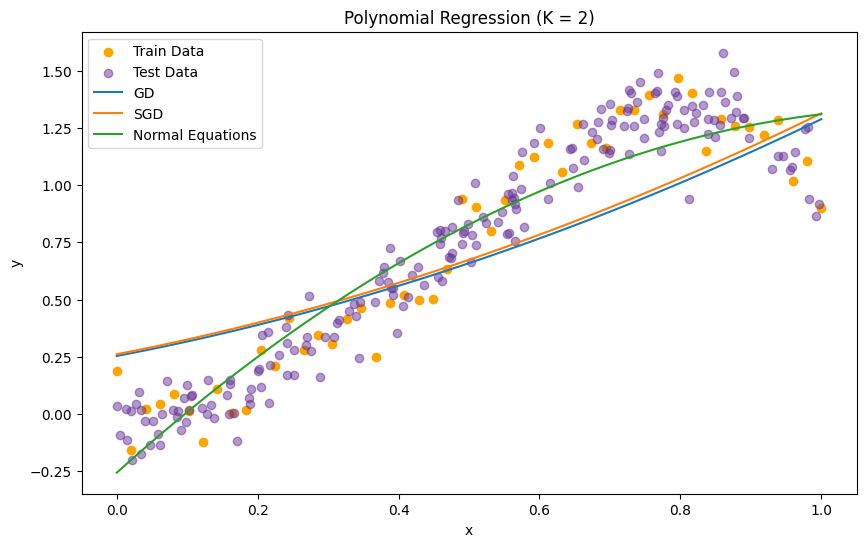

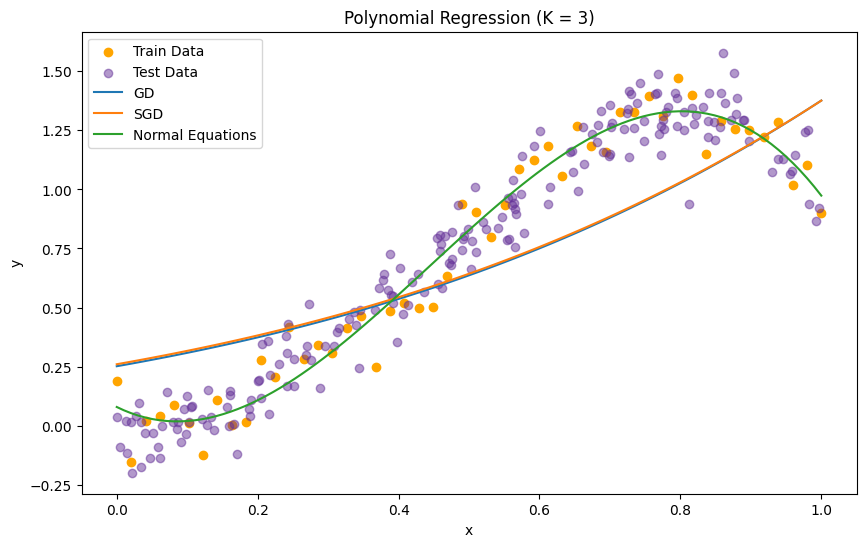

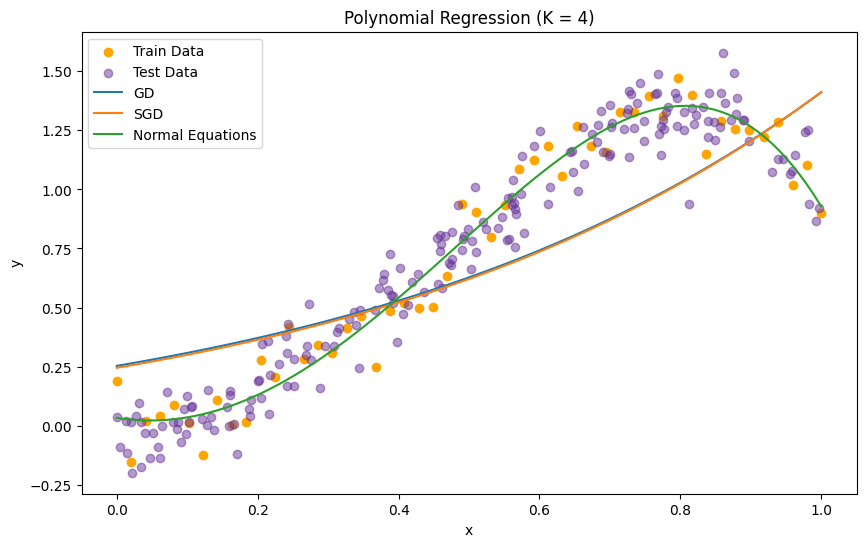

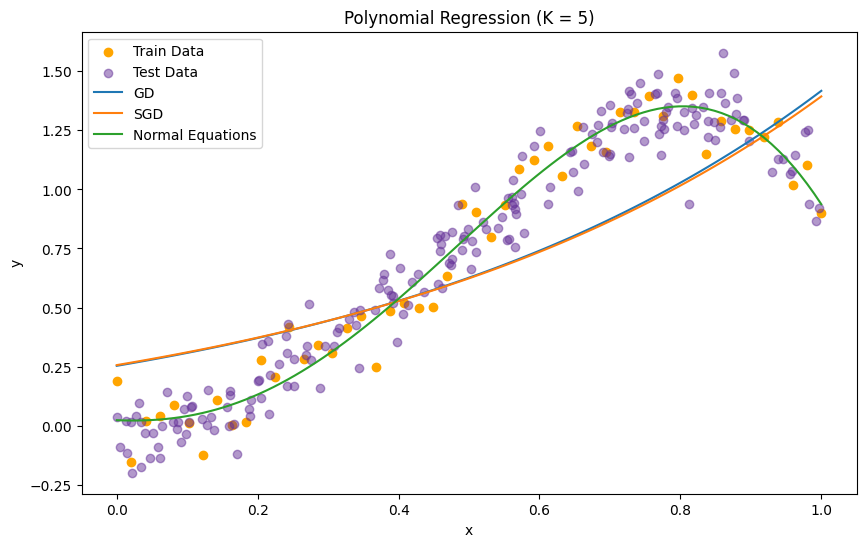

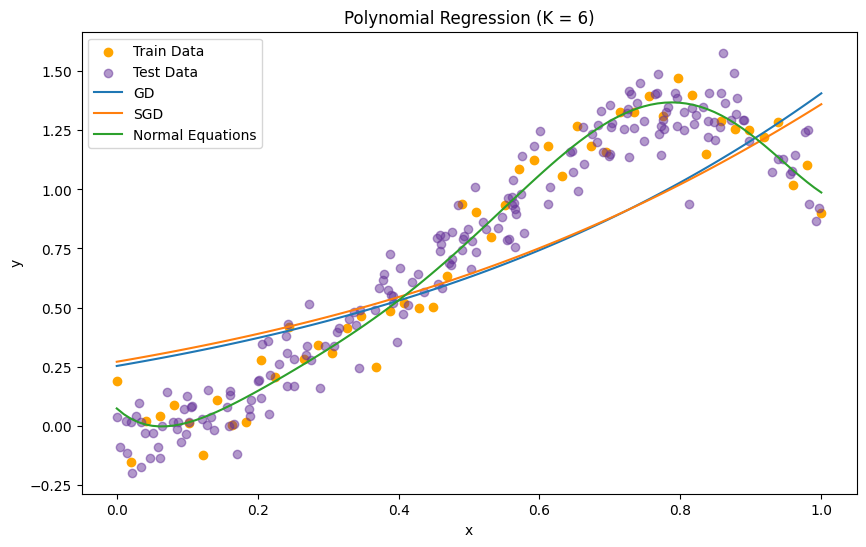

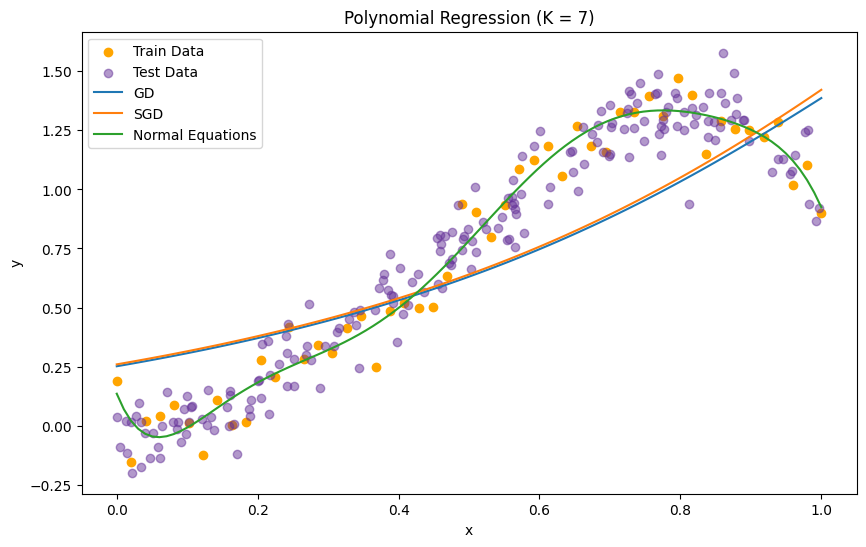

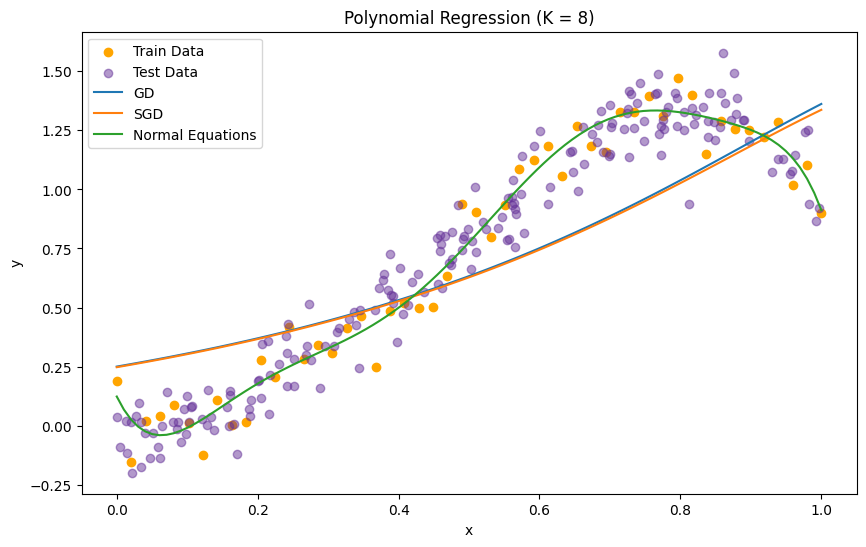

In [184]:
# Experiment with different polynomial degrees
max_K = 8
map_train_errors = []
map_test_errors = []

for K in range(1, max_K + 1):
    # Polynomial feature transformation
    X_train_poly = polynomial_features(X_train, K)
    X_test_poly = polynomial_features(X_test, K)

    # Estimation methods
    theta_gd = gradient_descent(X_train_poly, Y_train, map_gradient, lam=0.1)
    theta_sgd = stochastic_gradient_descent(X_train_poly, Y_train, map_gradient, lam=0.1)
    theta_ne = normal_equations_cholesky(X_train_poly, Y_train)

    # Compute errors
    gd_train_error = compute_error(X_train_poly, Y_train, theta_gd)
    sgd_train_error = compute_error(X_train_poly, Y_train, theta_sgd)
    ne_train_error = compute_error(X_train_poly, Y_train, theta_ne)

    gd_test_error = compute_error(X_test_poly, Y_test, theta_gd)
    sgd_test_error = compute_error(X_test_poly, Y_test, theta_sgd)
    ne_test_error = compute_error(X_test_poly, Y_test, theta_ne)
    
    # Visualization
    plot_regression(X_train, Y_train, X_test, Y_test, 
                    [theta_gd, theta_sgd, theta_ne], 
                    K, ['GD', 'SGD', 'Normal Equations'])

    # Store errors for plotting
    map_train_errors.append([gd_train_error, sgd_train_error, ne_train_error])
    map_test_errors.append([gd_test_error, sgd_test_error, ne_test_error])


Errors:
Degree 		 GD Test 		 GD Train 		 SGD Test 		 SGD Train 		 NE Test 		 NE Train
1 		 0.0902 		 0.0900 		 0.0905 		 0.0903 		 0.0289 		 0.0389
2 		 0.0703 		 0.0718 		 0.0675 		 0.0697 		 0.0217 		 0.0302
3 		 0.0702 		 0.0728 		 0.0702 		 0.0729 		 0.0112 		 0.0097
4 		 0.0717 		 0.0749 		 0.0718 		 0.0749 		 0.0107 		 0.0094
5 		 0.0721 		 0.0753 		 0.0741 		 0.0767 		 0.0108 		 0.0093
6 		 0.0713 		 0.0744 		 0.0729 		 0.0751 		 0.0108 		 0.0089
7 		 0.0699 		 0.0727 		 0.0685 		 0.0723 		 0.0113 		 0.0081
8 		 0.0681 		 0.0707 		 0.0695 		 0.0715 		 0.0113 		 0.0081


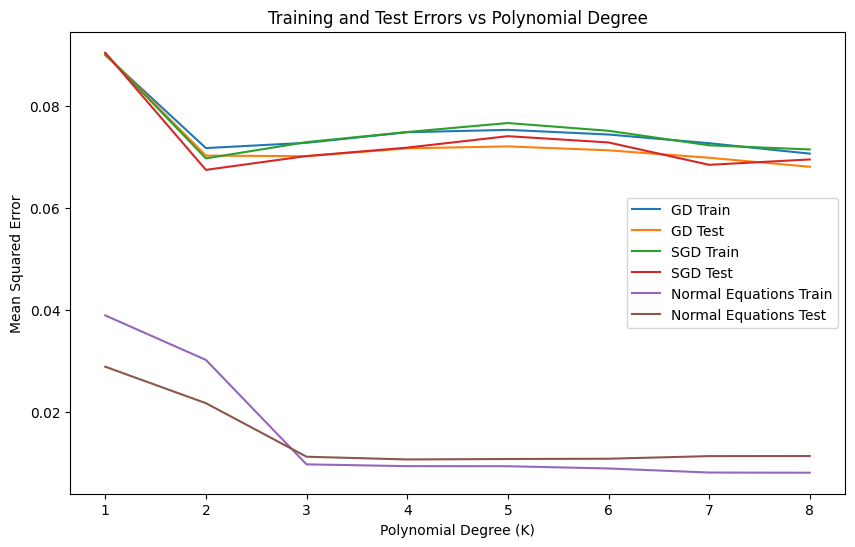

In [185]:
show_errors_and_plots(map_train_errors, map_test_errors, max_K)

#### Errors MLE vs MAP on the test set at different degrees

Errors on Test of MLE vs MAP vs Normal Equations:
Degree 		 MLE GD 		 MLE SGD 		 MAP GD 		 MAP SGD 		 NE
1 		 0.0289 		 0.0292 		 0.0902 		 0.0905 		 0.0289
2 		 0.0283 		 0.0292 		 0.0703 		 0.0675 		 0.0217
3 		 0.0195 		 0.0196 		 0.0702 		 0.0702 		 0.0112
4 		 0.0141 		 0.0144 		 0.0717 		 0.0718 		 0.0107
5 		 0.0114 		 0.0113 		 0.0721 		 0.0741 		 0.0108
6 		 0.0101 		 0.0102 		 0.0713 		 0.0729 		 0.0108
7 		 0.0098 		 0.0098 		 0.0699 		 0.0685 		 0.0113
8 		 0.0100 		 0.0100 		 0.0681 		 0.0695 		 0.0113


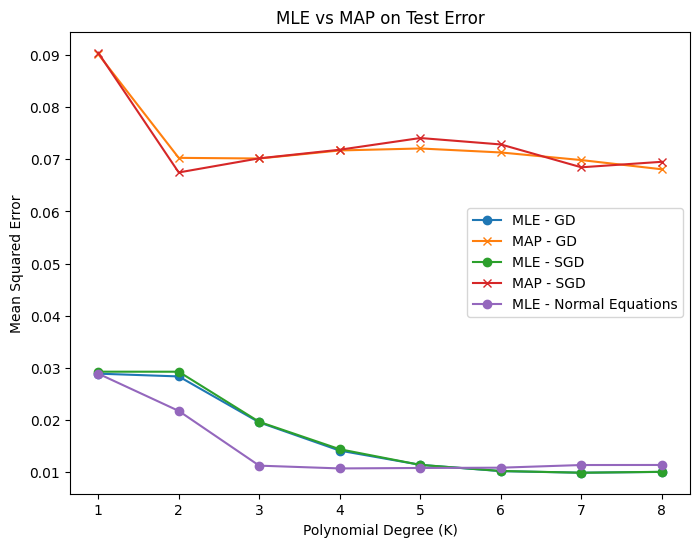

In [186]:
# Print MLE GD, MLE SGD, MAP GD, MAP SGD and NE errors
print("Errors on Test of MLE vs MAP vs Normal Equations:")
print("Degree \t\t MLE GD \t\t MLE SGD \t\t MAP GD \t\t MAP SGD \t\t NE")
for i in range(max_K):
    print(f"{i+1} \t\t {mle_test_errors[i][0]:.4f} \t\t {mle_test_errors[i][1]:.4f} \t\t "
          f"{map_test_errors[i][0]:.4f} \t\t {map_test_errors[i][1]:.4f} \t\t "
          f"{mle_test_errors[i][2]:.4f}")
    
# Plot MAP vs MLE errors on test
plt.figure(figsize=(8, 6))

x = range(1, max_K + 1)
methods = ['GD', 'SGD', 'Normal Equations']

for i in range(2):
    # MLE
    plt.plot(
        x,
        [mle_test_errors[k][i] for k in range(max_K)],
        marker='o',
        label=f'MLE - {methods[i]}'
    )
    # MAP
    plt.plot(
        x,
        [map_test_errors[k][i] for k in range(max_K)],
        marker='x',
        label=f'MAP - {methods[i]}'
    )
# Plot Normal Equation separately since it's not depeend on MLE or MAP
plt.plot(
    x,
    [mle_test_errors[k][2] for k in range(max_K)],
    marker='o',
    label=f'MLE - Normal Equations'
)

plt.title("MLE vs MAP on Test Error")
plt.xlabel("Polynomial Degree (K)")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

#### MAP on different values of $\lambda$

Lambda: 0.0001


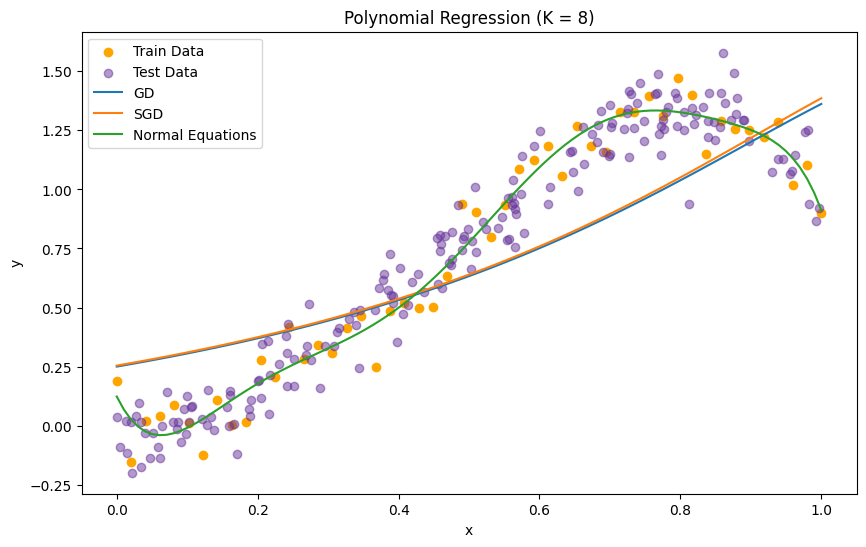

Lambda: 0.01


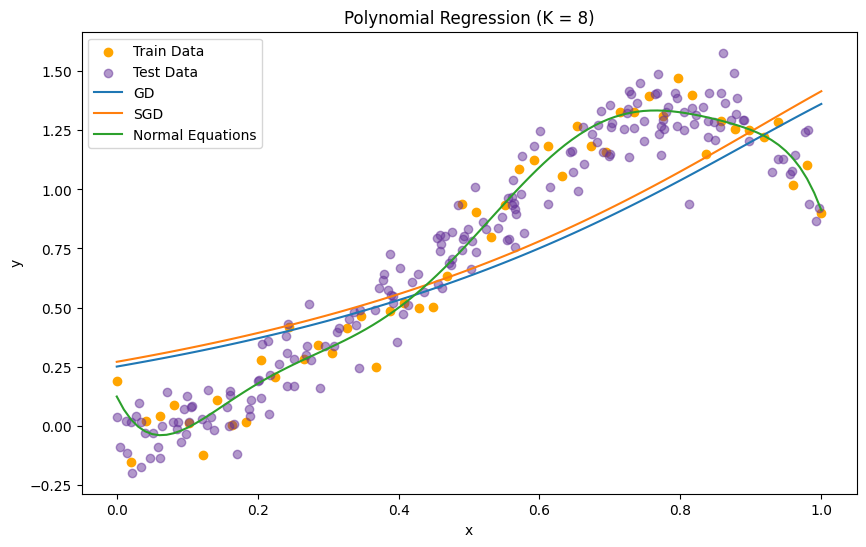

Lambda: 0.1


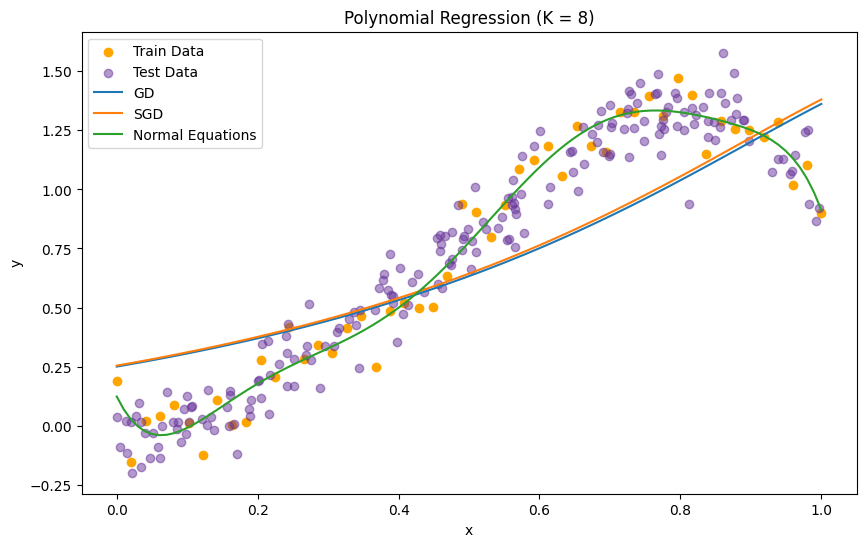

Lambda: 1


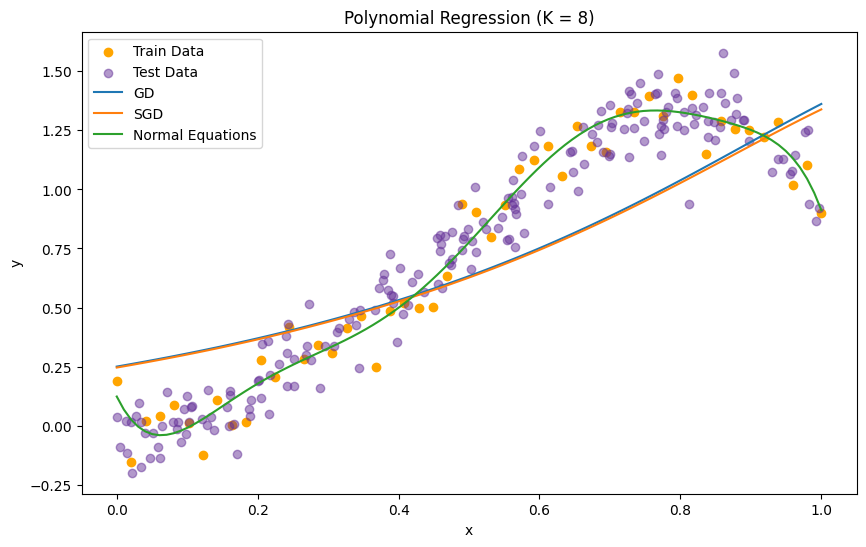

Lambda: 10


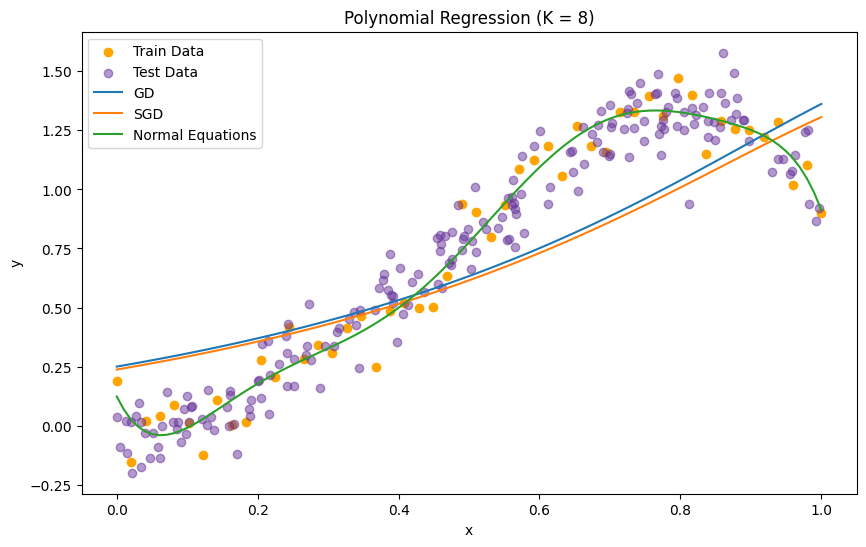

Lambda: 100


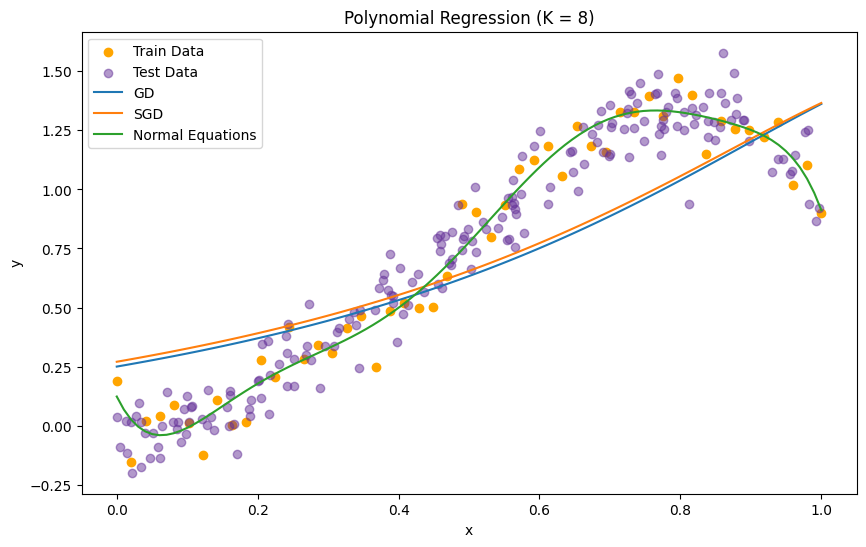

Lambda: 1000


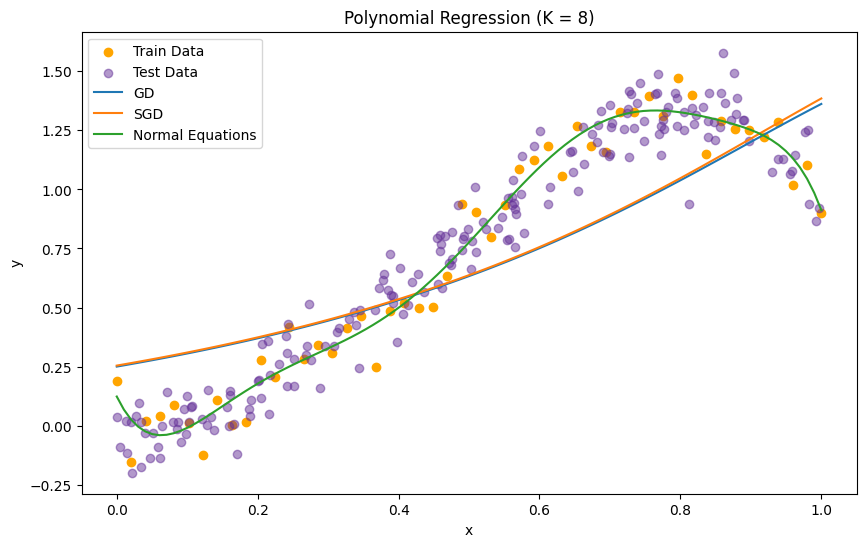

In [189]:

# MAP Experiments
K = 8
map_lambda_test_errors = []
map_lambda_train_errors = []
X_train_poly = polynomial_features(X_train, K)
X_test_poly = polynomial_features(X_test, K)

lambdas = [1e-4, 1e-2, 0.1, 1, 10, 100, 1000]
for lam in lambdas:
    # Estimation methods
    theta_gd = gradient_descent(X_train_poly, Y_train, map_gradient, lam=0.1)
    theta_sgd = stochastic_gradient_descent(X_train_poly, Y_train, map_gradient, lam=0.1)
    theta_ne = normal_equations_cholesky(X_train_poly, Y_train)

    # Compute errors
    gd_train_error = compute_error(X_train_poly, Y_train, theta_gd)
    sgd_train_error = compute_error(X_train_poly, Y_train, theta_sgd)
    ne_train_error = compute_error(X_train_poly, Y_train, theta_ne)

    gd_test_error = compute_error(X_test_poly, Y_test, theta_gd)
    sgd_test_error = compute_error(X_test_poly, Y_test, theta_sgd)
    ne_test_error = compute_error(X_test_poly, Y_test, theta_ne)

    # Store errors for plotting
    map_lambda_train_errors.append([gd_train_error, sgd_train_error, ne_train_error])
    map_lambda_test_errors.append([gd_test_error, sgd_test_error, ne_test_error])

    print (f"Lambda: {lam}")
    plot_regression(X_train, Y_train, X_test, Y_test, [theta_gd, theta_sgd, theta_ne], K, ['GD', 'SGD', 'Normal Equations'])


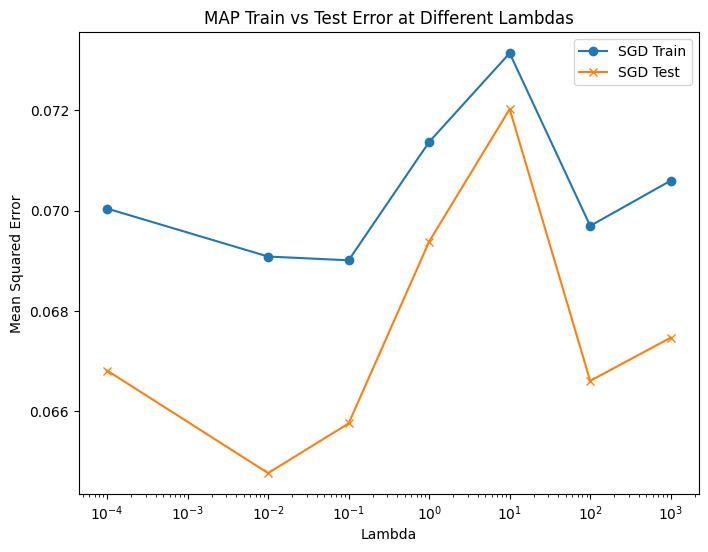

In [190]:
plt.figure(figsize=(8, 6))
train_err = [map_lambda_train_errors[j][1] for j in range(len(lambdas))]
test_err = [map_lambda_test_errors[j][1] for j in range(len(lambdas))]
plt.plot(lambdas, train_err, marker='o', label=f'SGD Train')
plt.plot(lambdas, test_err, marker='x', label=f'SGD Test')

plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('MAP Train vs Test Error at Different Lambdas')
plt.legend()
plt.show()